In [1]:
"""
Module to facilitate trading through Interactive Brokers's API
see: https://interactivebrokers.github.io/tws-api/index.html
Brent Maranzano
Dec. 14, 2018
Classes
    IBClient (EClient): Creates a socket to TWS or IBGateway, and handles
        sending commands to IB through the socket.
    IBWrapper (EWrapper): Hanldes the incoming data from IB. Many of these
        methods are callbacks from the request commands.
    IBApp (IBWrapper, IBClilent): This provides the main functionality. Many
        of the methods are over-rides of the IBWrapper commands to customize
        the functionality.
"""
print("ruinnn")
import os.path
import time
import logging
import threading
import json
import numpy as np
import pandas as pd
from datetime import datetime
from ibapi import wrapper
from ibapi.client import EClient
from ibapi.contract import Contract
from ibapi.common import OrderId, ListOfContractDescription, BarData,\
        HistogramDataList, TickerId
from ibapi.order import Order
from ibapi.order_state import OrderState

API_THREAD = None


def setup_logger():
    """Setup the logger.
    """
    if not os.path.exists("log"):
        os.makedirs("log")

    time.strftime("pyibapi.%Y%m%d_%H%M%S.log")

    recfmt = "(%(threadName)s) %(asctime)s.%(msecs)03d %(levelname)s" \
             "%(filename)s:%(lineno)d %(message)s"

    timefmt = '%y%m%d_%H:%M:%S'

    logging.basicConfig(
        filename=time.strftime("log/pyibapi.%y%m%d_%H%M%S.log"),
        filemode="w",
        level=logging.INFO,
        format=recfmt, datefmt=timefmt
    )
    logger = logging.getLogger()
    console = logging.StreamHandler()
    console.setLevel(logging.ERROR)
    logger.addHandler(console)
    logging.debug("now is %s", datetime.now())


class IBClient(EClient):
    """Subclass EClient, which delivers message to the TWS API socket.
    """
    def __init__(self, app_wrapper):
        EClient.__init__(self, app_wrapper)


class IBWrapper(wrapper.EWrapper):
    """Subclass EWrapper, which translates messages from the TWS API socket
    to the program.
    """
    def __init__(self):
        wrapper.EWrapper.__init__(self)


class HistoricalRequestError(Exception):
    """Exceptions generated during requesting historical stock price data.
    """
    def __init__(self, message, errors):
        super().__init__(message)

        self.errors = errors
        self.message = message


class IBApp(IBWrapper, IBClient):
    """Main program class. The TWS calls nextValidId after connection, so
    the method is over-ridden to provide an entry point into the program.
    class variables:
    saved_contracts (dict): keys are symbols, values are dictionaries of
        information to uniquely define a contract used for stock trading.
        {symbol: {'contract_info_dictionary'}}
    saved_orders (dict): keys are order ids, values are Order, Contract
        {id: {order: Order, contract: Contract}}
    TODO
    positions
    """
    def __init__(self):
        IBWrapper.__init__(self)
        IBClient.__init__(self, app_wrapper=self)

        self.order_id = None
        self.saved_contract_details = {}
        self.positions = []
        self._contract_details = {}
        self._saved_orders = {}
        self._open_orders = []
        self._historical_data = []
        self._historical_data_req_end = False
        self._histogram = None
        self._load_contracts('contract_file.json')

    def error(self, reqId: TickerId, errorCode: int, errorString: str):
        """Overide EWrapper error method.
        """
        super().error(reqId, errorCode, errorString)
        print(reqId)

    def _load_contracts(self, filename):
        """Load saved contracts.
        """
        try:
            with open(filename, mode='r') as file_obj:
                self.saved_contracts = json.load(file_obj)
        except FileNotFoundError:
            pass

    def _save_contracts(self):
        """Save contracts.
        """
        with open("contracts.json", mode='a') as file_obj:
            json.dump(self._contract_details, file_obj)

    def nextValidId(self, orderId: int):
        """Method of EWrapper.
        Sets the order_id class variable.
        This method is called from after connection completion, so
        provides an entry point into the class.
        """
        super().nextValidId(orderId)
        self.order_id = orderId
        return self

    def _get_next_order_id(self):
        """Retrieve the current class variable order_id and increment
        it by one.
        Returns (int) current order_id
        """
        #  reqIds can be used to update the order_id, if tracking is lost.
        # self.reqIds(-1)
        current_order_id = self.order_id
        self.order_id += 1
        return current_order_id

    def get_contract_details(self, symbol=None):
        """Find the contract (STK, USD, NYSE|NASDAY.NMS|ARGA) for the symbol.
        Upon execution of IB backend, the EWrapper.symbolSamples is called,
        which is over-ridden to save the contracts to a class dictionary.
        This function then monitors the class dictionary until
        the symbol is found and then returns the contract.
        Arguments:
            symbol (string): Ticker.
        Returns: (Contract) Contract for the symbol.
        """
        # If the symbol has not already been saved, look it up.
        if symbol not in self.saved_contract_details:
            self._contract_details = None
            # The IB server will call symbolSamples upon completion.
            self.reqMatchingSymbols(1001, symbol)

            # Loop until the server has completed the request.
            while self._contract_details is None:
                time.sleep(0.2)

            # Select the proper contract
            for contract in self._contract_details:
                if contract.symbol == symbol and contract.currency == "USD"\
                        and contract.secType == "STK":
                    # NYSE stock
                    if contract.primaryExchange == "NYSE":
                        break
                    # Common ETFs
                    elif contract.primaryExchange == "ARCA":
                        break
                    # Nasdaq stock
                    elif contract.primaryExchange == "NASDAQ.NMS":
                        contract.primaryExchange = "ISLAND"
                        break

            # Save the contract information needed for defining a Contract.
            self.saved_contract_details[symbol] = {
                'currency': contract.currency,
                'secType': contract.secType,
                'exchange': "SMART",
                'primaryExchange': contract.primaryExchange,
                'secIdType': contract.secIdType,
                'secId': contract.secId
            }

        return self.saved_contract_details[symbol]

    def symbolSamples(self, reqId: int,
                      contractDescriptions: ListOfContractDescription):
        """Callback from reqMatchingSymbols. Add contracts that are of
        secType=STK, currency=USD, and primaryExchange=(NYSE | ISLAND) to the
        class variable contract_search_results.
        """
        super().symbolSamples(reqId, contractDescriptions)

        # Add all contracts to the to a list that the calling function can
        # access.
        contracts = []
        for desc in contractDescriptions:
            contracts.append(desc.contract)
        # is complete.
        self._contract_details = contracts

    def make_contract(self, symbol):
        """Create a contract for the given symbol.
        Arguments:
        symbol (str): Ticker symbol
        """
        contract_info = self.get_contract_details(symbol)
        contract = Contract()
        contract.symbol = symbol
        contract.currency = contract_info['currency']
        contract.exchange = contract_info['exchange']
        contract.primaryExchange = contract_info['primaryExchange']
        contract.secType = contract_info['secType']
        contract.secId = contract_info['secId']

        return contract

    def get_positions(self):
        """Get the account positions. If the class variable, positions, exists,
        return that value, else call the EClient method reqPositions, wait for
        a short time and then return the class variable positions.
        Returns (dict): Dictionary of the positions information.
        """
        self.positions = []
        self.reqPositions()
        time.sleep(1)

        return pd.DataFrame.from_dict(self.positions).set_index('account')

    def position(self, account: str, contract: Contract, position: float,
                 avgCost: float):
        super().position(account, contract, position, avgCost)
        self.positions.append({
            'account': account,
            'symbol': contract.symbol,
            'secType': contract.secType,
            'position': position,
            'cost': avgCost
        })

    def positionEnd(self):
        """Cancel the position subscription after a return.
        """
        super().positionEnd()
        self.cancelPositions()

    def create_bracket_orders(self, req_orders=None):
        """Create orders, but do not place.
        Arguments:
        req_orders (list): list of dictionaries - keys are:
            symbol (str): Equity ticker symbol.
            instruction (str): "BUY" | "SELL"
            price (float): Order set price.
            quantity (float): Order quantity.
            outside_rth (bool): outside regular trading hours
            tif (str): Time in force "DAY" | "GTC"
            profit_price (float): Price for profit taking
            stop_price (float): Price for stop loss
            parent_id (int): Id of parent trade.
        """
        # If only a single contract (dict) is passed convert it
        # to a list with a single item.
        if not isinstance(req_orders, list):
            req_orders = [req_orders]

        for req_order in req_orders:
            contract = self.make_contract(symbol=req_order['symbol'])

            # Create the parent order
            order_id = self._get_next_order_id()
            parent = Order()
            parent.orderId = order_id
            parent.action = req_order['instruction']
            parent.orderType = "LMT"
            parent.totalQuantity = req_order['quantity']
            parent.lmtPrice = req_order['price']
            parent.outsideRth = req_order['outside_rth']
            parent.tif = req_order['tif']
            parent.transmit = False
            self._saved_orders[order_id] = {
                "order": parent, "contract": contract
            }

            # Create the profit taker order
            if req_order['profit_price'] is not None:
                order_id = self._get_next_order_id()
                profit_taker = Order()
                profit_taker.orderId = order_id
                profit_taker.action = "SELL"\
                    if req_order['instruction'] == "BUY" else "BUY"
                profit_taker.orderType = "LMT"
                profit_taker.totalQuantity = req_order['quantity']
                profit_taker.lmtPrice = req_order['profit_price']
                profit_taker.parentId = parent.orderId
                profit_taker.transmit = False
                self._saved_orders[order_id] = {
                    "order": profit_taker, "contract": contract
                }

            # Create stop loss order
            if req_order['stop_price'] is not None:
                order_id = self._get_next_order_id()
                stop_loss = Order()
                stop_loss.orderId = order_id
                stop_loss.action = "SELL"\
                    if req_order['instruction'] == "BUY" else "BUY"
                stop_loss.orderType = "STP"
                stop_loss.auxPrice = req_order['stop_price']
                stop_loss.totalQuantity = req_order['quantity']
                stop_loss.parentId = parent.orderId
                stop_loss.transmit = False
                self._saved_orders[order_id] = {
                    "order": stop_loss, "contract": contract
                }

    def create_trailing_stop_orders(self, req_orders=None):
        """Create a trailing stop order.
        Arguments:
        req_orders (list): list of dictionaries - keys are:
            symbol (str): Equity ticker symbol.
            instruction (str): "BUY" | "SELL"
            quantity (float): Order quantity.
            trail_stop_price (float): Trailing stop price
            trail_amount (float): Trailing amount in dollars.
            limit_offset (float): Offset of limit price
                for sell - limit offset is greater than trailing amount
                for buy - limit offset is less than trailing amount
            outside_rth (bool): outside regular trading hours
            tif (str): Time in force "DAY" | "GTC"
            parent_id (int): Id of parent trade.
        """
        # If only a single contract (dict) is passed convert it
        # to a list with a single item.
        if not isinstance(req_orders, list):
            req_orders = [req_orders]

        for req_order in req_orders:
            contract = self.make_contract(symbol=req_order['symbol'])

            # Create the order
            order_id = self._get_next_order_id()
            order = Order()
            order.orderId = order_id
            order.action = req_order['instruction']
            order.orderType = "TRAIL LIMIT"
            order.totalQuantity = req_order['quantity']
            order.trailStopPrice = req_order['trail_stop_price']
            order.auxPrice = req_order['trail_amount']
            order.lmtPriceOffset = req_order['limit_offset']
            order.outsideRth = req_order['outside_rth']
            order.tif = req_order['tif']
            order.transmit = False
            # TODO parent_id
            self._saved_orders[order_id] = {
                "order": order, "contract": contract
            }

    def create_stop_limit_orders(self, req_orders=None):
        """Create a trailing stop order.
        Arguments:
        req_orders (list): list of dictionaries - keys are:
            symbol (str): Equity ticker symbol.
            instruction (str): "BUY" | "SELL"
            quantity (float): Order quantity.
            stop_price (float): stop price
            limit_price (float): limit price.
            outside_rth (bool): outside regular trading hours
            tif (str): Time in force "DAY" | "GTC"
            profit_price (float): Profit taking price.
        """
        # If only a single contract (dict) is passed convert it
        # to a list with a single item.
        if not isinstance(req_orders, list):
            req_orders = [req_orders]

        for req_order in req_orders:
            contract = self.make_contract(symbol=req_order['symbol'])

            # Create the order
            order_id = self._get_next_order_id()
            order = Order()
            order.orderId = order_id
            order.action = req_order['instruction']
            order.orderType = "STP LMT"
            order.totalQuantity = req_order['quantity']
            order.lmtPrice = req_order['limit_price']
            order.auxPrice = req_order['stop_price']
            order.outsideRth = req_order['outside_rth']
            order.tif = req_order['tif']
            order.transmit = False
            self._saved_orders[order_id] = {
                "order": order, "contract": contract
            }

            # Create the profit taker order
            if req_order['profit_price'] is not None:
                profit_taker_order_id = self._get_next_order_id()
                profit_taker = Order()
                profit_taker.orderId = profit_taker_order_id
                profit_taker.action = "SELL"\
                    if req_order['instruction'] == "BUY" else "BUY"
                profit_taker.orderType = "LMT"
                profit_taker.totalQuantity = req_order['quantity']
                profit_taker.lmtPrice = req_order['profit_price']
                profit_taker.parentId = order.orderId
                profit_taker.transmit = False
                self._saved_orders[profit_taker_order_id] = {
                    "order": profit_taker, "contract": contract
                }

    def create_pegged_orders(self, req_orders=None):
        """Create a pegged to bench mark order.
        Arguments:
        req_orders (list): list of dictionaries - keys are:
            symbol (str): Equity ticker symbol.
            instruction (str): "BUY" | "SELL"
            quantity (float): Order quantity.
            starting_price (float): Order starting price.
            outside_rth (bool): outside regular trading hours
            tif (str): Time in force "DAY" | "GTC"
            peg_change_amount (float): Change of price for the target
            ref_change_amount (float): Change of price of the reference
            ref_contract_id (int): Contract ID of the reference
                SPY: ConID: 756733, exchange: ARCA
                QQQ: ConID: 320227571, exchange: NASDAQ
            ref_exchange (str): Exchange of the reference
            ref_price (float): Start price of the reference
            ref_lower_price (float): Lower ref price allowed
            ref_upper_price (float): Upper ref price allowed
        """
        # If only a single contract (dict) is passed convert it
        # to a list with a single item.
        if not isinstance(req_orders, list):
            req_orders = [req_orders]

        for req_order in req_orders:
            contract = self.make_contract(symbol=req_order['symbol'])

            # Create the parent order
            order_id = self._get_next_order_id()
            order = Order()
            order.orderId = order_id
            order.orderType = "PEG BENCH"
            order.action = req_order['instruction']
            order.totalQuantity = req_order['quantity']
            order.startingPrice = req_order['starting_price']
            order.isPeggedChangeAmountDecrease = False
            order.peggedChangeAmount = req_order['peg_change_amount']
            order.referenceChangeAmount = req_order['ref_change_amount']
            order.referenceContractId = req_order['ref_contract_id']
            order.referenceExchange = req_order['ref_exchange']
            order.stockRefPrice = req_order['ref_price']
            order.stockRangeLower = req_order['ref_lower_price']
            order.stockRangeUpper = req_order['ref_upper_price']
            order.transmit = False
            self._saved_orders[order_id] = {
                "order": order, "contract": contract
            }

    def get_saved_orders(self, symbol=None):
        """Return saved orders for symbol. If symbol is None
        return all saved orders.
        Returns (dict) {order_id: {order: order, contract: contract}}
        """
        if symbol is None:
            return self._saved_orders

        orders = dict()
        for oid, order in self._saved_orders.items():
            if order['contract'].symbol == symbol:
                orders[oid] = order
        return orders

    def place_order(self, order_id=None):
        """Place a saved order. from a previously created saved order with
        order_id.
        Arguments:
        order_id (int): The order_id of a previously created order.
        """
        if order_id in self._saved_orders:
            self.placeOrder(order_id, self._saved_orders[order_id]['contract'],
                            self._saved_orders[order_id]['order'])
        del self._saved_orders[order_id]

    def place_all_orders(self):
        """Place all the saved orders.
        """
        order_ids = list(self._saved_orders.keys())
        for order_id in order_ids:
            self.place_order(order_id=order_id)

    def get_open_orders(self):
        """Call the IBApi.EClient reqOpenOrders. Open orders are returned via
        the callback openOrder.
        """
        self.reqOpenOrders()

    def openOrder(self, orderId: OrderId, contract: Contract, order: Order,
                  orderState: OrderState):
        """Callback from reqOpenOrders(). Method is over-ridden from the
        EWrapper class.
        """
        super().openOrder(orderId, contract, order, orderState)
        self._open_orders.append({
            'order_id': orderId,
            'contract': contract,
            'order': order
        })

    def get_quotes(self, symbols=None):
        """Get a quote for the symbol. Callsback to
        Warning: This may incur fees!
        Arguments:
        symbols (str|list): Equity ticker symbol or list of ticker symbols.
        Returns (Panda Series): Last trade price for the symbols.
        """
        # If only a single symbol is passed convert it
        # to a list with a single item.
        if isinstance(symbols, str):
            symbols = [symbols]

        # Get the bar data for each symbol
        quotes = pd.Series(index=symbols)
        for symbol in symbols:
            quote = self._req_historical_data(
                symbol,
                end_date="",
                duration="2 D",
                size="1 min",
                info="TRADES",
                rth=False
            )
            quotes[symbol] = float(quote.iloc[-1]['close_price'])

        return quotes

    def get_price_history(self, symbols=None, start_date=None, end_date=None,
                          bar_size="1 day", rth=False):
        """Get the price history for symbols.
        Arguments:
        symbols (str|list): Equity ticker symbol or list of ticker symbols.
        start_date (datetime): First date for data retrieval.
        end_date (datetime): Last data for data retrieval.
        bar_size (str): Bar size (e.g. "1 min", "1 day", "1 month")
            for valid strings see:
               http://interactivebrokers.github.io/tws-api/historical_bars.html
        rth (bool): True to only return data within regular trading hours.
        return (pandas.DataFrame): Price history data.
        """
        if end_date is None:
            end_date = datetime.today()

        # If only a single symbol is passed convert it
        # to a list with a single item.
        if isinstance(symbols, str):
            symbols = [symbols]

        # Estimate a duration string for the given date span.
        # TODO fix duration of seconds
        duration = end_date - start_date
        if duration.days >= 365:
            duration = "{} Y".format(int(duration.days/365))
        elif duration.days < 365 and duration.days > 1:
            duration = "{} D".format(np.busday_count(start_date.date(), end_date.date()))
        else:
            duration = "{} S".format(duration.seconds)
        # Get the bar data for each symbol
        bars = {}
        for symbol in symbols:
            try:
                bars[symbol] = self._req_historical_data(
                    symbol,
                    end_date=end_date.strftime("%Y%m%d %H:%M:%S"),
                    duration=duration,
                    size=bar_size,
                    info="TRADES",
                    rth=rth
                )
            except HistoricalRequestError as err:
                print(err.message)

        # Format the bars dictionary for conversion into DataFrame
        bars = {(outerKey, innerKey): values for outerKey, innerDict
                in bars.items() for innerKey, values in innerDict.items()}
        bars = pd.DataFrame(bars)

        # Reindex the bars using real time stamps.
        if (bar_size.find("secs") != -1 or bar_size.find("min") != -1 or
            bar_size.find("hour") != -1):
            index = [datetime.strptime(d, "%Y-%m-%d %H:%M:%S")
                     for d in bars.index]
        else:
            index = [datetime.strptime(d, "%Y-%m-%d") for d in bars.index]
        bars.index = index

        # Try to get rid of any missing data.
        bars.fillna(method="ffill", inplace=True)

        return bars

    
    def _req_historical_data(self, symbol, end_date="", duration="20 D",
                             size="1 day", info="TRADES", rth=False):
        """Get historical data using reqHistoricalData. Upon completion the
        server will callback historicalData, which is overridden.
        http://interactivebrokers.github.io/tws-api/historical_bars.html#hd_duration
        Arguments:
        symbol (str): Ticker symbol
        end_date (datetime): Last date requested
        duration (str): How far to go back - valid options: (S, D, W, M, Y)
        size (str): Bar size (see link)
        info (str): Type of data to return (see link)
        rth (bool): Return data only in regular trading hours"""
        contract = self.make_contract(symbol)

        self._historical_data = []
        self._historical_data_req_end = False
        self.reqHistoricalData(2001, contract, end_date, duration, size,
                               info, rth, 1, False, [])

        # Wait until the request has returned (make it blocking).
        start_time = datetime.now()
        while self._historical_data_req_end is not True:
            if (datetime.now() - start_time).microseconds > 1000000:
                raise HistoricalRequestError(
                    "Timeout occurred while retrieving price data for {}"
                    .format(symbol),
                    "_req_historical_data({})".format(symbol)
                )
            time.sleep(0.2)

        # Convert the data into
        bars_index = [b.date[:4]+"-"+b.date[4:6]+"-"+b.date[6:]
                      for b in self._historical_data]
        bars_data = [[float(b.open), float(b.high), float(b.low),
                      float(b.close), float(b.volume)]
                     for b in self._historical_data]

        bars = pd.DataFrame(
            index=bars_index,
            columns=['open_price', 'high', 'low', 'close_price', 'volume'],
            data=bars_data
        )

        return bars
    def historicalData(self, reqId: int, bar: BarData):
        """Overridden method from EWrapper. Checks to make sure reqId matches
        the self.historical_data[req_id] to confirm correct symbol.
        """
        self._historical_data.append(bar)

    def historicalDataEnd(self, reqId: int, start: str, end: str):
        """Overrides the EWrapper method.
        """
        self._historical_data_req_end = True

    def get_histogram(self, symbol=None, period="20 days"):
        """Get histograms of the symbols.
        Arguments:
        symbol (str): Equity ticker symbol or list of ticker symbols.
        period (str): Number of days to collect data.
        Returns (?): Histograms of the symbols
        """
        # If only a single symbol is passed convert it
        # to a list with a single item.

        contract = self.make_contract(symbol)
        self._histogram = None
        self.reqHistogramData(3001, contract, False, period)
        while self._histogram is None:
            time.sleep(0.2)

        histogram = pd.DataFrame(
            columns=["price", "count"],
            data=[[float(p.price), int(p.count)] for p in self._histogram]
        )

        return histogram

    def histogramData(self, reqId: int, items: HistogramDataList):
        """EWrapper method called from reqHistogramData.
        http://interactivebrokers.github.io/tws-api/histograms.html
        """
        self._histogram = items

    def keyboardInterrupt(self):
        """Stop exectution.
        """
        pass

    def quick_bracket(self, symbol=None, instruction=None, quantity=None,
                      amount=1000, limit_percent=None, profit_percent=None):
        """Calculate bracket order for symbol using a limit provided by
        limit_percent.
        Arguments
        symbol (str): Ticker symbol
        instruction (str): "BUY" | "SELL"
        quantity (int): Number of shares
        amount (float): Amount in dollars to trade
        limit_percent (float): Percent change from current quote to set limit.
        profit_percent (float): Percent change from limit price to take profit.
        Returns (dict) Parameters necessary to place a bracket order.
        """
        # Calculate a reasonable change if limit_percent is not given.
        if limit_percent is None:
            if instruction == "BUY":
                limit_percent = -0.3
            if instruction == "SELL":
                limit_percent = 0.3

        # Calculate a reasonable change if limit_percent is not given.
        if profit_percent is None:
            if instruction == "BUY":
                profit_percent = 0.3
            if instruction == "SELL":
                profit_percent = -0.3

        # Get the quote
        quote = self.get_quotes(symbol).loc[symbol]

        # Calculate the limit price from the limit_percent.
        limit_price = round(quote * (1 + limit_percent/100.), 2)
        # Calculate the profit price from the limit_price.
        profit_price = round(limit_price * (1 + profit_percent/100.), 2)

        # Calculate quantity if amount was provided.
        if quantity is None:
            quantity = int(amount / quote)

        req_order = {
            'symbol': symbol,
            'instruction': instruction,
            'quantity': quantity,
            'price': limit_price,
            'tif': "DAY",
            'outside_rth': True,
            'profit_price': profit_price,
            'stop_price': None
        }
        self.create_bracket_orders(req_orders=[req_order])

        for order_id in list(self.get_saved_orders(symbol).keys()):
            self.place_order(order_id=order_id)


def main(port=7497):
    """Entry point into the program.
    Arguments:
    port (int): Port number that IBGateway, or TWS is listening.
    """
    global API_THREAD
    try:
        app = IBApp()
        app.connect("127.0.0.1", port, clientId=0)
        print("serverVersion:%s connectionTime:%s" % (app.serverVersion(),
                                                      app.twsConnectionTime()))
        API_THREAD = threading.Thread(target=app.run)
        API_THREAD.start()
        return app
    except KeyboardInterrupt:
        pass


if __name__ == "__main__":
    import sys
    # port number socker server is using (paper: 7497, live: 7496)
    # PORT_NUMBER = sys.argv[1]
    PORT_NUMBER = 7497
    app = main(port=PORT_NUMBER)


ruinnn
serverVersion:151 connectionTime:b'20200827 08:59:30 EST'


ERROR -1 2104 Market data farm connection is OK:usfarm
ERROR -1 2106 HMDS data farm connection is OK:ushmds.nj
ERROR -1 2106 HMDS data farm connection is OK:ushmds
ERROR -1 2158 Sec-def data farm connection is OK:secdefil


-1
-1
-1
-1


In [18]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt



df = app.get_price_history( symbols=['TSLA'], start_date=datetime(2020,7,1), end_date=datetime(2020,8,24),
                  bar_size="1 min", rth=False)
display(df)
# os.chdir('C:\\S\\stocks')
try:a.to_csv("C:/S/a.csv")
except Exception as e: print(e)

TSLA                                     
                    open_price     high      low close_price volume
2020-06-30 04:13:00    1003.63  1003.63  1003.63     1003.63    1.0
2020-06-30 04:14:00    1003.63  1003.63  1003.63     1003.63    0.0
2020-06-30 04:15:00    1003.63  1003.63  1003.63     1003.63    0.0
2020-06-30 04:16:00    1003.63  1003.63  1003.63     1003.63    0.0
2020-06-30 04:17:00    1003.63  1003.63  1003.63     1003.63    0.0
...                        ...      ...      ...         ...    ...
2020-08-21 19:55:00    2042.00  2042.00  2042.00     2042.00    0.0
2020-08-21 19:56:00    2042.00  2042.00  2041.50     2041.50    5.0
2020-08-21 19:57:00    2041.05  2041.05  2041.04     2041.05    1.0
2020-08-21 19:58:00    2042.00  2042.51  2042.00     2042.51   13.0
2020-08-21 19:59:00    2042.50  2042.50  2042.50     2042.50    1.0

[36217 rows x 5 columns]

name 'a' is not defined


,open_price,high,low,close_price,volume
2020-06-30 04:13:00,1003.63,1003.63,1003.63,1003.63,1.0
2020-06-30 04:14:00,1003.63,1003.63,1003.63,1003.63,0.0
2020-06-30 04:15:00,1003.63,1003.63,1003.63,1003.63,0.0
2020-06-30 04:16:00,1003.63,1003.63,1003.63,1003.63,0.0
2020-06-30 04:17:00,1003.63,1003.63,1003.63,1003.63,0.0
...,...,...,...,...,...
2020-08-21 19:55:00,2042.00,2042.00,2042.00,2042.00,0.0
2020-08-21 19:56:00,2042.00,2042.00,2041.50,2041.50,5.0
2020-08-21 19:57:00,2041.05,2041.05,2041.04,2041.05,1.0
2020-08-21 19:58:00,2042.00,2042.51,2042.00,2042.51,13.0


Test Statistic                    -3.293523
p-value                            0.015170
#Lags Used                        48.000000
Number of Observations Used    28924.000000
Critical Value (1%)               -3.430576
Critical Value (5%)               -2.861640
Critical Value (10%)              -2.566823
dtype: float64

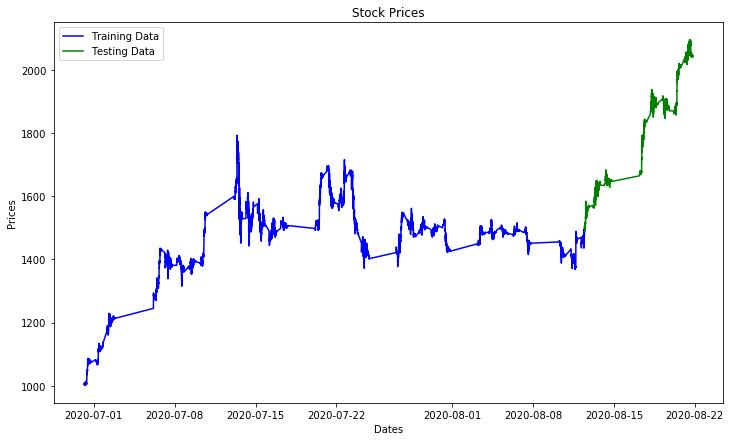

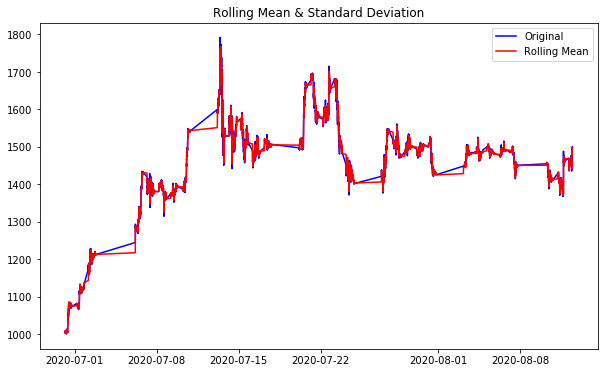

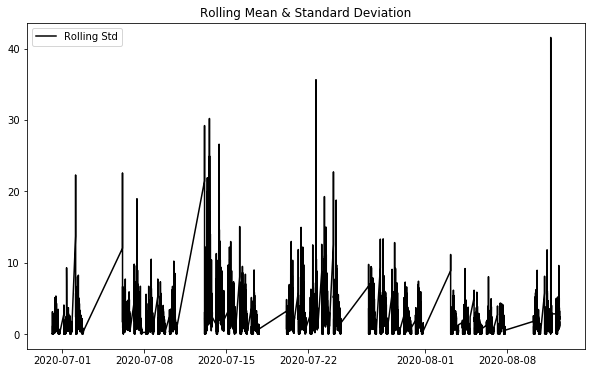

In [19]:
from statsmodels.tsa.stattools import adfuller

dfug = df['TSLA']
display(dfug)
train_data, test_data = dfug.iloc[0:int(len(df)*0.8), :], dfug.iloc[int(len(df)*0.8):, :]
plt.figure(figsize=(12,7))
plt.title('Stock Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_data['close_price'], 'blue', label='Training Data')
plt.plot(test_data['close_price'], 'green', label='Testing Data')
plt.legend()

window = 7
train_series = train_data['close_price']

#Determing rolling statistics
rolmean = train_series.rolling(window).mean()
rolstd = train_series.rolling(window).std()

#Plot rolling statistics:
fig = plt.figure(figsize=(10, 6))
orig = plt.plot(train_series, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')

plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation');

fig = plt.figure(figsize=(10, 6))
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation');




dftest = adfuller(train_series, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
display(dfoutput)

Test Statistic                   -25.246609
p-value                            0.000000
#Lags Used                        47.000000
Number of Observations Used    28924.000000
Critical Value (1%)               -3.430576
Critical Value (5%)               -2.861640
Critical Value (10%)              -2.566823
dtype: float64

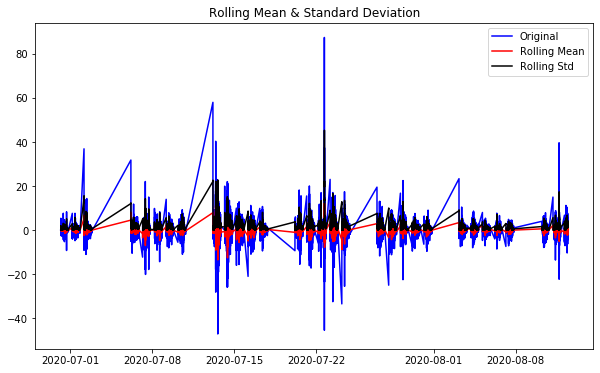

In [20]:
train_diff = train_series.diff()
train_diff = train_diff.dropna(inplace = False)
#Determing rolling statistics
rolmean = train_diff.rolling(window).mean()
rolstd = train_diff.rolling(window).std()

#Plot rolling statistics:
fig = plt.figure(figsize=(10, 6))
orig = plt.plot(train_diff, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation');

dftest = adfuller(train_diff, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

In [21]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200 / (np.abs(y_pred) + np.abs(y_true))))
test_series = test_data['close_price']
test_diff = test_series.diff()
test_diff = test_diff.dropna(inplace = False)


history = [x for x in train_diff]
# print(history)
predictions = list()

for t in range(len(test_diff)):
    print(t)
    # START_CODE_HERE - call the ARIMA Method with history and params
    model = ARIMA(history, order=(5,1,0))  # initialize the model with history and right order of parameters
    model_fit = model.fit(disp=0)  # fit the model
#     print(model_fit.summary())
    # END_CODE_HERE

    output = model_fit.forecast()  # use forecast on the fitted model
    yhat = output[0][0]
    predictions.append(yhat)

    obs = test_diff[t]
    history.append(obs)

    if t % 100 == 0:
      print('Test Series Point: {}\tPredicted={}, Expected={}'.format(t, yhat, obs))

0
Test Series Point: 0	Predicted=0.9431829898632345, Expected=-0.9700000000000273
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
Test Series Point: 100	Predicted=0.06194778577565163, Expected=0.2300000000000182
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
Test Series Point: 200	Predicted=-1.5506578656610275, Expected=-3.2000000000000455
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
2

1602
1603
1604
1605
1606
1607
1608
1609
1610
1611
1612
1613
1614
1615
1616
1617
1618
1619
1620
1621
1622
1623
1624
1625
1626
1627
1628
1629
1630
1631
1632
1633
1634
1635
1636
1637
1638
1639
1640
1641
1642
1643
1644
1645
1646
1647
1648
1649
1650
1651
1652
1653
1654
1655
1656
1657
1658
1659
1660
1661
1662
1663
1664
1665
1666
1667
1668
1669
1670
1671
1672
1673
1674
1675
1676
1677
1678
1679
1680
1681
1682
1683
1684
1685
1686
1687
1688
1689
1690
1691
1692
1693
1694
1695
1696
1697
1698
1699
1700
Test Series Point: 1700	Predicted=-0.36462931592059067, Expected=-0.9400000000000546
1701
1702
1703
1704
1705
1706
1707
1708
1709
1710
1711
1712
1713
1714
1715
1716
1717
1718
1719
1720
1721
1722
1723
1724
1725
1726
1727
1728
1729
1730
1731
1732
1733
1734
1735
1736
1737
1738
1739
1740
1741
1742
1743
1744
1745
1746
1747
1748
1749
1750
1751
1752
1753
1754
1755
1756
1757
1758
1759
1760
1761
1762
1763
1764
1765
1766
1767
1768
1769
1770
1771
1772
1773
1774
1775
1776
1777
1778
1779
1780
1781
1782
1783
1784


3021
3022
3023
3024
3025
3026
3027
3028
3029
3030
3031
3032
3033
3034
3035
3036
3037
3038
3039
3040
3041
3042
3043
3044
3045
3046
3047
3048
3049
3050
3051
3052
3053
3054
3055
3056
3057
3058
3059
3060
3061
3062
3063
3064
3065
3066
3067
3068
3069
3070
3071
3072
3073
3074
3075
3076
3077
3078
3079
3080
3081
3082
3083
3084
3085
3086
3087
3088
3089
3090
3091
3092
3093
3094
3095
3096
3097
3098
3099
3100
Test Series Point: 3100	Predicted=1.7837827905896575, Expected=0.9400000000000546
3101
3102
3103
3104
3105
3106
3107
3108
3109
3110
3111
3112
3113
3114
3115
3116
3117
3118
3119
3120
3121
3122
3123
3124
3125
3126
3127
3128
3129
3130
3131
3132
3133
3134
3135
3136
3137
3138
3139
3140
3141
3142
3143
3144
3145
3146
3147
3148
3149
3150
3151
3152
3153
3154
3155
3156
3157
3158
3159
3160
3161
3162
3163
3164
3165
3166
3167
3168
3169
3170
3171
3172
3173
3174
3175
3176
3177
3178
3179
3180
3181
3182
3183
3184
3185
3186
3187
3188
3189
3190
3191
3192
3193
3194
3195
3196
3197
3198
3199
3200
Test Series Point:

4443
4444
4445
4446
4447
4448
4449
4450
4451
4452
4453
4454
4455
4456
4457
4458
4459
4460
4461
4462
4463
4464
4465
4466
4467
4468
4469
4470
4471
4472
4473
4474
4475
4476
4477
4478
4479
4480
4481
4482
4483
4484
4485
4486
4487
4488
4489
4490
4491
4492
4493
4494
4495
4496
4497
4498
4499
4500
Test Series Point: 4500	Predicted=-3.0026533059140876e-07, Expected=0.0
4501
4502
4503
4504
4505
4506
4507
4508
4509
4510
4511
4512
4513
4514
4515
4516
4517
4518
4519
4520
4521
4522
4523
4524
4525
4526
4527
4528
4529
4530
4531
4532
4533
4534
4535
4536
4537
4538
4539
4540
4541
4542
4543
4544
4545
4546
4547
4548
4549
4550
4551
4552
4553
4554
4555
4556
4557
4558
4559
4560
4561
4562
4563
4564
4565
4566
4567
4568
4569
4570
4571
4572
4573
4574
4575
4576
4577
4578
4579
4580
4581
4582
4583
4584
4585
4586
4587
4588
4589
4590
4591
4592
4593
4594
4595
4596
4597
4598
4599
4600
Test Series Point: 4600	Predicted=0.6143277070326794, Expected=0.0
4601
4602
4603
4604
4605
4606
4607
4608
4609
4610
4611
4612
4613
4614
4

5872
5873
5874
5875
5876
5877
5878
5879
5880
5881
5882
5883
5884
5885
5886
5887
5888
5889
5890
5891
5892
5893
5894
5895
5896
5897
5898
5899
5900
Test Series Point: 5900	Predicted=-0.28451251467007677, Expected=-1.1400000000001
5901
5902
5903
5904
5905
5906
5907
5908
5909
5910
5911
5912
5913
5914
5915
5916
5917
5918
5919
5920
5921
5922
5923
5924
5925
5926
5927
5928
5929
5930
5931
5932
5933
5934
5935
5936
5937
5938
5939
5940
5941
5942
5943
5944
5945
5946
5947
5948
5949
5950
5951
5952
5953
5954
5955
5956
5957
5958
5959
5960
5961
5962
5963
5964
5965
5966
5967
5968
5969
5970
5971
5972
5973
5974
5975
5976
5977
5978
5979
5980
5981
5982
5983
5984
5985
5986
5987
5988
5989
5990
5991
5992
5993
5994
5995
5996
5997
5998
5999
6000
Test Series Point: 6000	Predicted=-0.32217379670655233, Expected=0.8699999999998909
6001
6002
6003
6004
6005
6006
6007
6008
6009
6010
6011
6012
6013
6014
6015
6016
6017
6018
6019
6020
6021
6022
6023
6024
6025
6026
6027
6028
6029
6030
6031
6032
6033
6034
6035
6036
6037
6038

Testing Mean Squared Error: 18.435
Symmetric Mean absolute percentage error: 0.186


,open_price,high,low,close_price,volume,predictions
2020-08-12 11:11:00,1500.36,1503.98,1500.00,1503.77,335.0,1503.770000
2020-08-12 11:12:00,1503.76,1504.01,1501.26,1502.80,277.0,1504.713183
2020-08-12 11:13:00,1503.03,1504.96,1502.85,1504.54,234.0,1505.467099
2020-08-12 11:14:00,1504.55,1507.01,1504.38,1506.37,516.0,1505.737762
2020-08-12 11:15:00,1506.81,1507.25,1503.05,1503.42,375.0,1506.575049
...,...,...,...,...,...,...
2020-08-21 19:55:00,2042.00,2042.00,2042.00,2042.00,0.0,2044.258711
2020-08-21 19:56:00,2042.00,2042.00,2041.50,2041.50,5.0,2044.423281
2020-08-21 19:57:00,2041.05,2041.05,2041.04,2041.05,1.0,2044.479318
2020-08-21 19:58:00,2042.00,2042.51,2042.00,2042.51,13.0,2044.465083


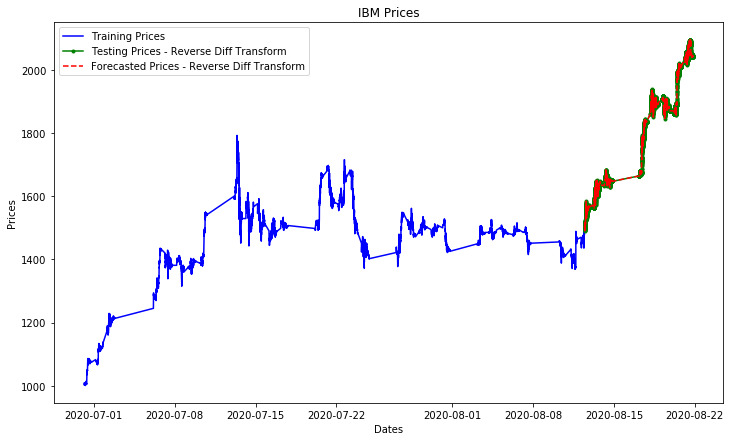

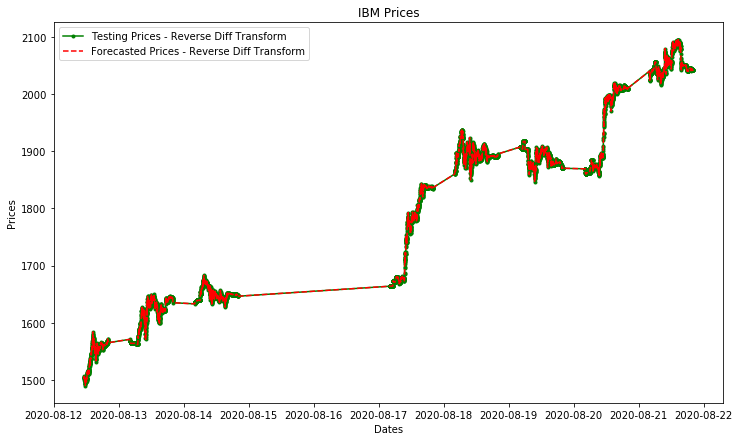

In [32]:
reverse_test_diff = np.r_[test_series.iloc[0], test_diff].cumsum()
reverse_predictions = np.r_[test_series.iloc[0], predictions].cumsum()
reverse_test_diff.shape, reverse_predictions.shape

error = mean_squared_error(reverse_test_diff, reverse_predictions)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(reverse_test_diff, reverse_predictions)
print('Symmetric Mean absolute percentage error: %.3f' % error2)

reverse_test_diff_series = pd.Series(reverse_test_diff)
reverse_test_diff_series.index = test_series.index

reverse_predictions_series = pd.Series(reverse_test_diff)
reverse_predictions_series.index = test_series.index

plt.figure(figsize=(12,7))
plt.title('IBM Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_series, color='blue', label='Training Prices')
plt.plot(reverse_test_diff_series, color='green', marker='.', label='Testing Prices - Reverse Diff Transform')
plt.plot(reverse_test_diff_series, color='red', linestyle='--', label='Forecasted Prices - Reverse Diff Transform')
plt.legend();

plt.figure(figsize=(12,7))
plt.title('IBM Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(reverse_test_diff_series, color='green', marker='.', label='Testing Prices - Reverse Diff Transform')
plt.plot(reverse_test_diff_series, color='red', linestyle='--', label='Forecasted Prices - Reverse Diff Transform')
plt.legend();

mc = test_data.copy()
mc['predictions'] = reverse_predictions
display(mc)
mc.to_csv('mc.csv')